Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

In [14]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [15]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

# Choose figure

In [16]:
# from PIL import Image, ImageDraw
# import random

# # 加载图片并获取尺寸
# image_path = '/root/autodl-tmp/INCODE-main/deep_image/data/inpainting/kate.png'  # 更改为你的图片路径
# image = Image.open(image_path)
# width, height = image.size

# # 创建一个与原图相同尺寸的全白遮罩
# mask = Image.new('RGB', (width, height), 'white')
# draw = ImageDraw.Draw(mask)

# # 设置被遮罩的像素比例，例如0.1代表10%
# mask_ratio = 0.99

# # 计算需要遮罩的像素总数
# total_pixels = width * height
# mask_pixels = int(total_pixels * mask_ratio)

# # 随机选择并遮罩像素点
# for _ in range(mask_pixels):
#     x = random.randint(0, width - 1)
#     y = random.randint(0, height - 1)
#     draw.point((x, y), fill='black')

# # 保存遮罩图片
# mask_image_path = '/root/autodl-tmp/INCODE-main/deep_image/data/inpainting/mask_image.jpg'  # 更改为你希望保存遮罩的路径
# mask.save(mask_image_path)

# print(f"Mask image saved to {mask_image_path}.")


In [17]:
from PIL import Image
import numpy as np
import random

# 加载图片并获取尺寸
image_path = '/root/autodl-tmp/HOIN/im.jpg'  # 更改为你的图片路径
image = Image.open(image_path)
width, height = image.size
print(width, height)
# 创建一个与原图相同尺寸的全1矩阵（代表白色）
mask_matrix = np.ones((height, width), dtype=np.uint8)

# 设置被遮罩的像素比例，例如0.1代表10%
mask_ratio = 0.9

# 计算需要遮罩的像素总数
total_pixels = width * height
mask_pixels = int(total_pixels * mask_ratio)

# 生成所有可能的像素点坐标
all_pixels = [(x, y) for x in range(width) for y in range(height)]

# 随机选择不重复的像素点
selected_pixels = random.sample(all_pixels, mask_pixels)

# 将选中的像素点在矩阵中设置为0（黑色）
for x, y in selected_pixels:
    mask_matrix[y, x] = 0

# 将二维矩阵扩展为三维（以适配RGB），然后转换为PIL图像
mask_image = Image.fromarray(np.stack([mask_matrix*255]*3, axis=-1))

# 保存遮罩图片
mask_image_path = '/root/autodl-tmp/INCODE-main/deep_image/data/inpainting/mask_image.jpg'  # 更改为你希望保存遮罩的路径
mask_image.save(mask_image_path)

print(f"Mask image saved to {mask_image_path}.")


582 572
Mask image saved to /root/autodl-tmp/INCODE-main/deep_image/data/inpainting/mask_image.jpg.


In [18]:
# ## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

# ## Fig 7 (top)
img_path  = '/root/autodl-tmp/HOIN/im.jpg'
mask_path = '/root/autodl-tmp/INCODE-main/deep_image/data/inpainting/mask_image.jpg'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

# Load mask

In [19]:
img_pil, img_np = get_image(img_path, imsize)
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

### Center crop

In [20]:
# img_mask_pil = crop_image(img_mask_pil, dim_div_by)
# img_pil      = crop_image(img_pil,      dim_div_by)

# img_np      = pil_to_np(img_pil)
# img_mask_np = pil_to_np(img_mask_pil)

### Visualize

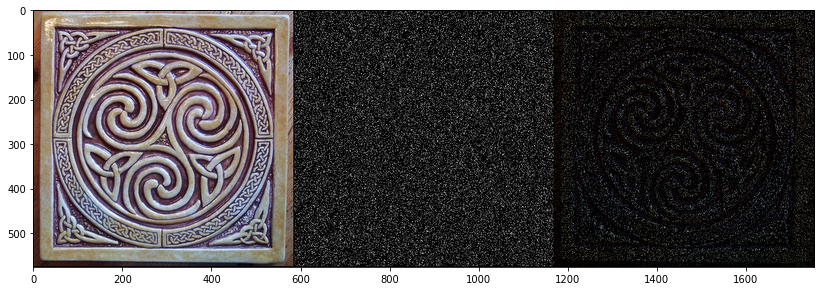

In [21]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)
plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

# Setup

In [22]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [23]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01 
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 3,
               num_channels_up   = [128] * 3,
               num_channels_skip = [0] * 3,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('celtic_spiral_knot.jpg' in img_path) or ('im.jpg' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise'
    input_depth = 64
    LR = 0.02
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif 'library.png' in img_path:
    
    INPUT = 'noise'
    input_depth = 1
    
    num_iter = 3001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [24]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3043587


In [25]:
# img_var = torch_to_np(mask_var)
# plot_image_grid([img_var], factor=5);

# Main loop

In [26]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    # if reg_noise_std > 0:
    #     net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out, img_var)
    total_loss.backward()
    rec = torch_to_np(out).transpose(1,2,0)
    ori = img_np.transpose(1,2,0)
    psnr= compare_psnr(rec,ori)
    print ('Iteration %05d    Loss %f    Psnr %f'   % (i, total_loss.item(),psnr), '\r', end='')
    # if  PLOT and i % show_every == 0:
    #     out_np = torch_to_np(out)
    #     plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Starting optimization with ADAM


  0%|          | 0/5001 [00:00<?, ?it/s]

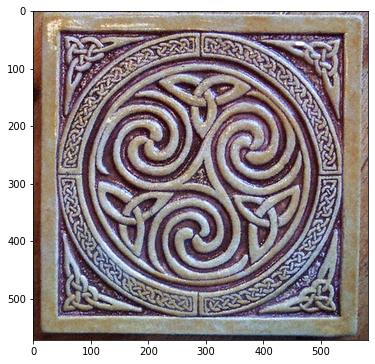

In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [ ]:
import cv2
out_np=torch.tensor(out_np).clone().detach()
best_img_save_np = np.array(out_np.clone().detach()).transpose(1, 2, 0)

best_img_save_name='/root/autodl-tmp/INCODE-main/data/result/'+'best0_8.png'
cv2.imwrite(best_img_save_name,best_img_save_np[:,:,::-1]*255)


True